In [1]:
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from flowMC.nfmodel.rqSpline import MaskedCouplingRQSpline
from flowMC.proposal.MALA import MALA
from flowMC.Sampler import Sampler
import corner
import matplotlib.pyplot as plt
import numpy as np

n_dim = 5

def target_dual_moon(x, data=None):
    """
    Term 2 and 3 separate the distribution and smear it along the first and second dimension
    """
    term1 = 0.5 * ((jnp.linalg.norm(x) - 2) / 0.1) ** 2
    term2 = -0.5 * ((x[:1] + jnp.array([-3.0, 3.0])) / 0.8) ** 2
    term3 = -0.5 * ((x[1:2] + jnp.array([-3.0, 3.0])) / 0.6) ** 2
    return -(term1 - logsumexp(term2) - logsumexp(term3))

In [2]:
n_chains = 20

rng_key, subkey = jax.random.split(jax.random.PRNGKey(42))
initial_position = jax.random.normal(subkey, shape=(n_chains, n_dim)) * 100

n_dim = 5
n_layers = 4
hidden_size = [32, 32]
num_bins = 8
data = jnp.zeros(n_dim)
rng_key, subkey = jax.random.split(rng_key)
model = MaskedCouplingRQSpline(
    n_dim, n_layers, hidden_size, num_bins, subkey
)
MALA_Sampler = MALA(target_dual_moon, True, step_size=0.1)

2024-04-17 13:38:50.355220: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
from flowMC.strategy.optimization import optimization_Adam

n_loop_training = 20
n_loop_production = 20
n_local_steps = 100
n_global_steps = 10
num_epochs = 5

learning_rate = 0.005
momentum = 0.9
batch_size = 5000
max_samples = 5000


rng_key, subkey = jax.random.split(rng_key)
nf_sampler = Sampler(
    n_dim,
    subkey,
    {'data': data},
    MALA_Sampler,
    model,
    n_loop_training=n_loop_training,
    n_loop_production=n_loop_production,
    n_local_steps=n_local_steps,
    n_global_steps=n_global_steps,
    n_chains=n_chains,
    n_epochs=num_epochs,
    learning_rate=learning_rate,
    momentum=momentum,
    batch_size=batch_size,
    use_global=True,
)
print(nf_sampler.strategies)

['n_dim', 'n_chains', 'n_local_steps', 'n_global_steps', 'n_loop', 'output_thinning', 'verbose']
[<flowMC.strategy.global_tuning.GlobalTuning object at 0x7f0546352a10>, <flowMC.strategy.global_tuning.GlobalSampling object at 0x7f053c1bd4d0>]


In [4]:
nf_sampler.sample(initial_position, data={'data':data})

Global Tuning:   0%|          | 0/20 [00:00<?, ?it/s]

Compiling MALA body


Global Sampling: 100%|██████████| 20/20 [00:00<00:00, 35.21it/s]


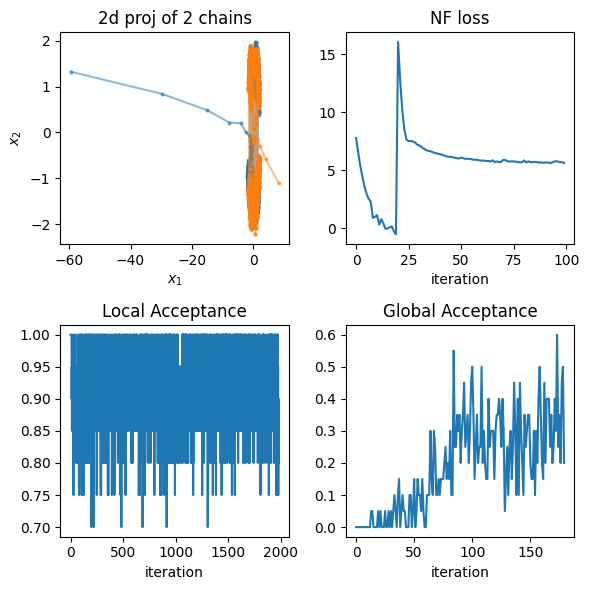

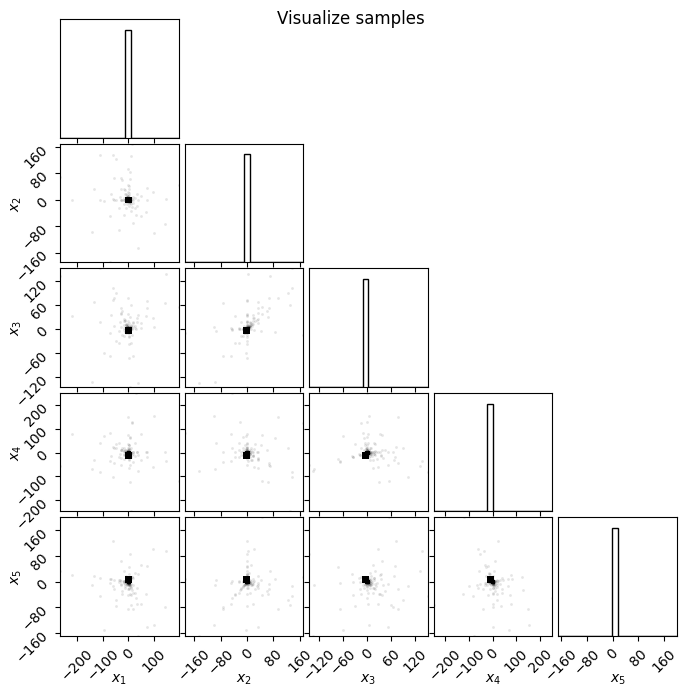

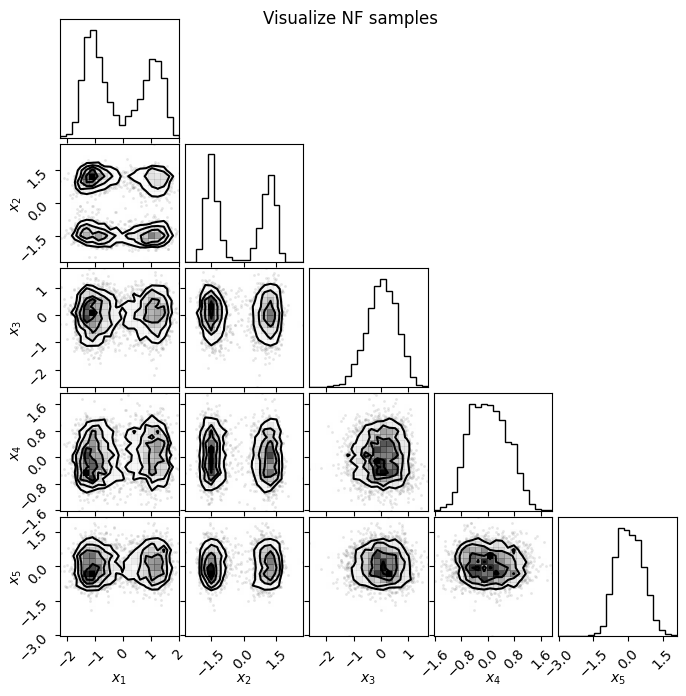

In [5]:
out_train = nf_sampler.get_sampler_state(training=True)
chains = np.array(out_train["chains"])
global_accs = np.array(out_train["global_accs"])
local_accs = np.array(out_train["local_accs"])
loss_vals = np.array(out_train["loss_vals"])
rng_key, subkey = jax.random.split(rng_key)
nf_samples = np.array(nf_sampler.sample_flow(subkey, 3000))


# Plot 2 chains in the plane of 2 coordinates for first visual check
plt.figure(figsize=(6, 6))
axs = [plt.subplot(2, 2, i + 1) for i in range(4)]
plt.sca(axs[0])
plt.title("2d proj of 2 chains")

plt.plot(chains[0, :, 0], chains[0, :, 1], "o-", alpha=0.5, ms=2)
plt.plot(chains[1, :, 0], chains[1, :, 1], "o-", alpha=0.5, ms=2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.sca(axs[1])
plt.title("NF loss")
plt.plot(loss_vals.reshape(-1))
plt.xlabel("iteration")

plt.sca(axs[2])
plt.title("Local Acceptance")
plt.plot(local_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[3])
plt.title("Global Acceptance")
plt.plot(global_accs.mean(0))
plt.xlabel("iteration")
plt.tight_layout()
plt.show(block=False)

labels = ["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"]
# Plot all chains
figure = corner.corner(chains.reshape(-1, n_dim), labels=labels)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize samples")
plt.show(block=False)

# Plot Nf samples
figure = corner.corner(nf_samples, labels=labels)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize NF samples")
plt.show()

In [6]:
from flowMC.strategy.optimization import optimization_Adam

n_loop_training = 20
n_loop_production = 20
n_local_steps = 100
n_global_steps = 10
num_epochs = 5

learning_rate = 0.005
momentum = 0.9
batch_size = 5000
max_samples = 5000

Adam_opt = optimization_Adam(n_steps=10000, learning_rate=1, noise_level= 1)

rng_key, subkey = jax.random.split(rng_key)
nf_sampler = Sampler(
    n_dim,
    subkey,
    {'data': data},
    MALA_Sampler,
    model,
    n_loop_training=n_loop_training,
    n_loop_production=n_loop_production,
    n_local_steps=n_local_steps,
    n_global_steps=n_global_steps,
    n_chains=n_chains,
    n_epochs=num_epochs,
    learning_rate=learning_rate,
    momentum=momentum,
    batch_size=batch_size,
    use_global=True,
    strategies=[Adam_opt, 'default'],
)
print(nf_sampler.strategies)
nf_sampler.sample(initial_position, data={'data':data})

['n_dim', 'n_chains', 'n_local_steps', 'n_global_steps', 'n_loop', 'output_thinning', 'verbose']
[<flowMC.strategy.optimization.optimization_Adam object at 0x7f0454133850>, <flowMC.strategy.global_tuning.GlobalTuning object at 0x7f04340a60d0>, <flowMC.strategy.global_tuning.GlobalSampling object at 0x7f054637e590>]
Using Adam optimization


Global Sampling: 100%|██████████| 20/20 [00:00<00:00, 37.64it/s]


In [7]:
nf_sampler.summary['AdamOptimization']['final_positions'][1]

Array([ 1.2080525e+00, -1.6088760e+00, -1.3536543e-42,  0.0000000e+00,
        0.0000000e+00], dtype=float32)

In [8]:
nf_sampler.summary['AdamOptimization']['initial_positions'][1]

Array([   8.188838 ,   -1.1033533, -145.09247  ,  -54.12119  ,
         87.737915 ], dtype=float32)

In [9]:
nf_sampler.summary['AdamOptimization']['initial_log_prob'][1], nf_sampler.summary['AdamOptimization']['final_log_prob'][1]

(Array(-1551947.5, dtype=float32), Array(-5.203574, dtype=float32))

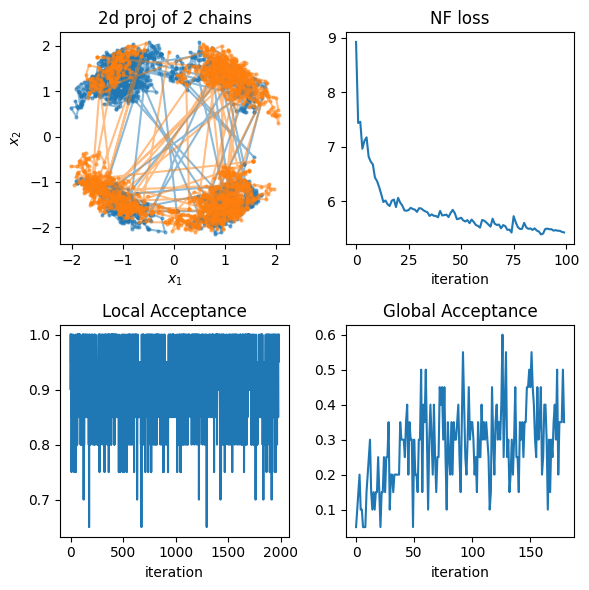

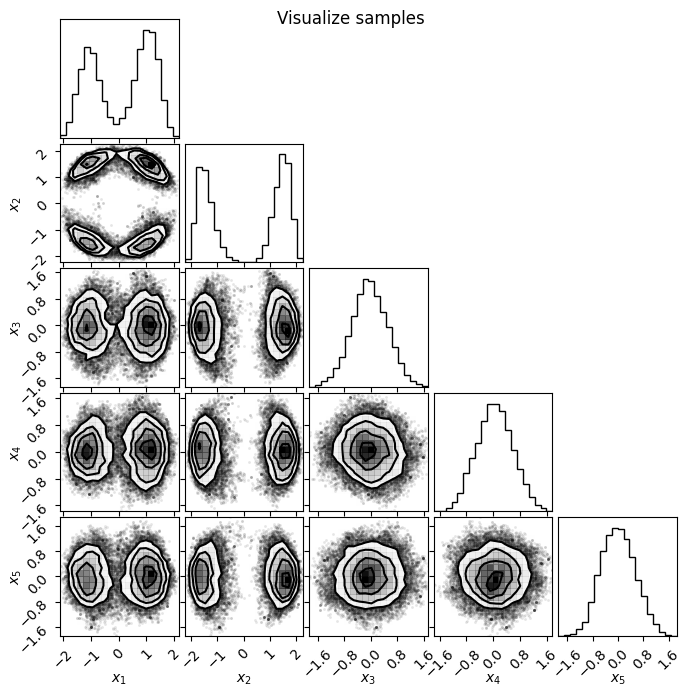

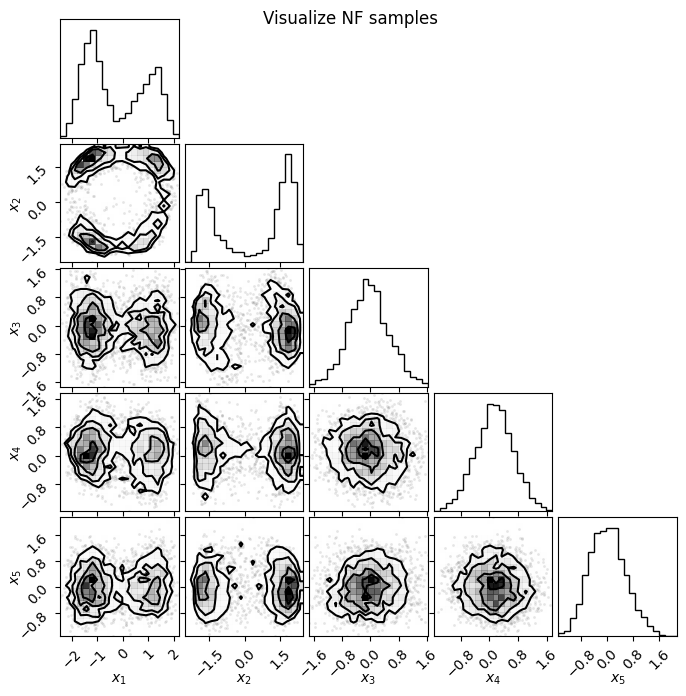

In [10]:
out_train = nf_sampler.get_sampler_state(training=True)
chains = np.array(out_train["chains"])
global_accs = np.array(out_train["global_accs"])
local_accs = np.array(out_train["local_accs"])
loss_vals = np.array(out_train["loss_vals"])
rng_key, subkey = jax.random.split(rng_key)
nf_samples = np.array(nf_sampler.sample_flow(subkey, 3000))


# Plot 2 chains in the plane of 2 coordinates for first visual check
plt.figure(figsize=(6, 6))
axs = [plt.subplot(2, 2, i + 1) for i in range(4)]
plt.sca(axs[0])
plt.title("2d proj of 2 chains")

plt.plot(chains[0, :, 0], chains[0, :, 1], "o-", alpha=0.5, ms=2)
plt.plot(chains[1, :, 0], chains[1, :, 1], "o-", alpha=0.5, ms=2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.sca(axs[1])
plt.title("NF loss")
plt.plot(loss_vals.reshape(-1))
plt.xlabel("iteration")

plt.sca(axs[2])
plt.title("Local Acceptance")
plt.plot(local_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[3])
plt.title("Global Acceptance")
plt.plot(global_accs.mean(0))
plt.xlabel("iteration")
plt.tight_layout()
plt.show(block=False)

labels = ["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"]
# Plot all chains
figure = corner.corner(chains.reshape(-1, n_dim), labels=labels)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize samples")
plt.show(block=False)

# Plot Nf samples
figure = corner.corner(nf_samples, labels=labels)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize NF samples")
plt.show()